# Crime in Vancouver / CSC 503 - Data Mining Project



**Jimmy Lai** (V00939923) - **Mona Malik** (V00935224) - **Andrea Castaneda** (V00933486)
***

In [1]:
import warnings
warnings.filterwarnings('ignore')

(we will be ignoring the warnings in the project, this cell of code does not change the results)

# Introduction

**What is the problem?**

Vancouver, like all big cities its size, is a very safe place to live or visit with a pretty low crime rate.  However, it still have its share of crime and illegal activities.

In the project, we would like to analyze and predict whether a person would encounter crime, given a known when and where.  When as in what time of the day and where as in the neighbourhood the person is in.

By completing the project, we should have a better understanding of which part of the city we should avoid at a specific time.

If the analysis is successful, it will be a huge help to both the general public and the police force of Vancouver.

**What is our approach?**

We will be testing out two classifiers, decision tree and Gaussian naive Bayes, to use our dataset on.

After getting primary results, we will choose a classifier in specific to tune the hyperparameters to see if we can get better results.

**What are our claims?**

As stated above, Vancouver is a safe city in general.  However, like other cities its size, Vancouver have its share of crime hotspot.

For example, Downtown Eastside Vancouver is infamous for its higher crime rates, but what exactly does that mean?  After the project, we can say with certainty that Downtown Eastside is actually not a dangerous place in terms of assault, but it does have a high property crime rate.  This means while it is fine to have a afternoon stroll in the area, you would probably want to park your car some place else.

Before diving into the project, using our knowledge of Vancouver and our understanding of how a human functions, we will make the following claims.

1. Crime rate will spike in the afternoon, when people are getting out of work and school

2. Crime rate will spike on off-days, which includes weekends and holidays.

3. There will be neighbourhoods with high specific crime rates, such as Downtown Eastside and property crimes, as mentioned above.

# The Dataset

**Where is the data from?  How was the data collected?**

The data is from the Vancouver Open Data Catalogue.  It is collected by the Vancouver Police Department over the years and is updated once a week on Sunday mornings.

The specific dataset we will be using in the project includes crime data from 2003/01/01 to 2019/11/18.

Included is the link to the dataset:
https://geodash.vpd.ca/opendata/

**A quick view at the data**

As can seen below, our dataset have 10 columns and 624038 rows in total.

In [2]:
import pandas as pd

data = pd.read_csv('crimedata_csv_all_years.csv')

**A more descriptive view at the data**

As can be seen below, the features of the dataset includes:

1. **TYPE:** Type of crime
2. **YEAR:** Year when the reported crime activity occurred
3. **MONTH:** Month when the reported crime activity occurred
4. **DAY:** Day when the reported crime activity occurred
5. **HOUR:** Hour when the reported crime activity occurred
6. **MINUTE:** Minute when the reported crime activity occurred
7. **HUNDRED_BLOCK:** Generalized location of the report crime activity
8. **NEIGHBOURHOODN:** Neighbourhood where the reported crime activity occurred
9. **X:** Coordinate values projected in UTM Zone 10
10. **Y:** Coordinate values projected in UTM Zone 10

Our target class will be the column "TYPE", since we are trying to predict whether crime will occur.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624038 entries, 0 to 624037
Data columns (total 10 columns):
TYPE             624038 non-null object
YEAR             624038 non-null int64
MONTH            624038 non-null int64
DAY              624038 non-null int64
HOUR             624038 non-null int64
MINUTE           624038 non-null int64
HUNDRED_BLOCK    624025 non-null object
NEIGHBOURHOOD    559076 non-null object
X                623918 non-null float64
Y                623918 non-null float64
dtypes: float64(2), int64(5), object(3)
memory usage: 47.6+ MB


# Pre-processing

Before we start, lets import the libraries we will be using in the project.

In [4]:
from datetime import date, timedelta
from shapely.geometry import Point, Polygon
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

import descartes
import holidays
import pickle
import time
import utm

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

**Data screening / cleaning**

Let's start by taking a look at the dataset.

In [5]:
data.head()

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
0,Break and Enter Commercial,2012,12,14,8,52,NaN,Oakridge,491285.000000,5.453433e+06
1,Break and Enter Commercial,2019,3,7,2,6,10XX SITKA SQ,Fairview,490612.964805,5.457110e+06
2,Break and Enter Commercial,2019,8,27,4,12,10XX ALBERNI ST,West End,491007.779775,5.459174e+06
3,Break and Enter Commercial,2014,8,8,5,13,10XX ALBERNI ST,West End,491015.943352,5.459166e+06
4,Break and Enter Commercial,2005,11,14,3,9,10XX ALBERNI ST,West End,491021.385727,5.459161e+06


Now, let's check how many missing values are in it.

We can see that only columns "HUNDRED_BLOCK", "NEIGHBOURHOOD", "X" and "Y" have missing values.

In [6]:
def missing_value_describe(data):
    missing_value_stats = (data.isnull().sum() / len(data)*100)

    missing_value_col_count = sum(missing_value_stats > 0)
    missing_value_stats = missing_value_stats.sort_values(ascending=False)[:missing_value_col_count]

    print("Number of columns with missing values:", missing_value_col_count)
    if missing_value_col_count != 0:
        print("Missing percentage (descending):")
        print(missing_value_stats)

missing_value_describe(data)

Number of columns with missing values: 4
Missing percentage (descending):
NEIGHBOURHOOD    10.409943
Y                 0.019230
X                 0.019230
HUNDRED_BLOCK     0.002083
dtype: float64


We will fill the missing values in these columns with dummy variables.

Columns "HUNDRED_BLOCK" and "NEIGHBOURHOOD" are filled with "N/A".

Columns "X" and "Y" are filled with 0.  Since the utm coordinates for Vancouver makes it impossible for the "X" value to be 0, by filling missing values with 0, we can be sure it is a dummy variable instead of a actual coordinate.

In [7]:
data['HUNDRED_BLOCK'].fillna('N/A', inplace = True)
data['NEIGHBOURHOOD'].fillna('N/A', inplace = True)
data['X'].fillna(0, inplace = True)
data['Y'].fillna(0, inplace = True)

After filling in the missing values, let's take a closer look at entries with "NEIGHBOURHOOD = N/A" and figure out how to reduce the number of it.

The column "NEIGHBOURHOOD" is extremely important to us since our prediction circles around its value.

In [8]:
data.loc[data['NEIGHBOURHOOD']=="N/A"].head()

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
38807,Break and Enter Commercial,2007,9,23,18,5,X NK_LOC ST,N/A,492757.48676,5.458792e+06
38808,Break and Enter Commercial,2007,11,1,14,38,X NK_LOC ST,N/A,492757.48676,5.458792e+06
38809,Break and Enter Commercial,2005,5,18,18,30,"X NK_LOC ST ""SQUAMISH""",N/A,492757.48676,5.458792e+06
105232,Break and Enter Residential/Other,2004,6,3,14,20,X NK_LOC ST,N/A,492757.48676,5.458792e+06
105233,Break and Enter Residential/Other,2008,3,13,7,0,X NK_LOC ST,N/A,492757.48676,5.458792e+06


Upon inspection, we can see that there are entries with usable location data, columns "X" and "Y" (the utm coordinates).

Lets use those to fill in the "NEIGHBOURHOOD" values.

For each entry that have "NEIGHBOURHOOD = N/A" and "X != 0", we use its utm coordinates and search for entries that are "NEIGHBOURHOOD != N/A" near its physical location.

If the search is unsuccessful and no such entry exists near it, we increase the search window and execute the search again.

If the search is successful, we do a majority vote and assume the missing "NEIGHBOURHOOD" value is it.

In [9]:
def fixneighbourhood(x, y, z):
    if x != 'N/A':
        return x
    elif x == 'N/A' and y == 0:
        return x
    
    search_win = 1
    
    while(1):
        search = data.query('X <= ' + str(y) + ' + ' + str(search_win) + ' and X >= ' + str(y) + ' - ' + str(search_win) + ' and Y <= ' + str(z) + ' + ' + str(search_win) + ' and Y >= ' + str(z) + ' - ' + str(search_win) + ' and NEIGHBOURHOOD != "N/A"')
        if len(search['NEIGHBOURHOOD'].unique()) == 0:
            search_win *= 3
            continue
        else:
            return search['NEIGHBOURHOOD'].mode()[0]

data['NEIGHBOURHOOD'] = data.apply(lambda x : fixneighbourhood(x.NEIGHBOURHOOD, x.X, x.Y), axis = 1)


After we tried filling in all the missing values in the column "NEIGHBOURHOOD", we should get rid of the entries that are not filled by our process above and are still missing the "NEIGHBOURHOOD" value.

However, since visualization uses these entries, we will remove them in the experiment/analysis section.

Since we are trying to predict whether crime will occur given a when and where, we should have "No Crime" included in our dataset as well.  Otherwise, our model will assume crime always occurs.

We first sort the dataset by the columns "YEAR", "MONTH", "DAY", "HOUR", "NEIGHBOURHOOD" in order.

Then, we insert entries of "TYPE = No Crime" into the dataset where the set {"HOUR", "NEIGHBOURHOOD"} does not exist.

Now, we have at least one entry every hour in every neighbourhood.

In [10]:
data = data.sort_values(['YEAR', 'MONTH', 'DAY', 'HOUR', 'NEIGHBOURHOOD']).reset_index(drop = True)

def range_date(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

neighbourhoods = data['NEIGHBOURHOOD'].unique()
neighbourhoods = np.delete(neighbourhoods, np.where(neighbourhoods == 'N/A'), axis=0)

data_append_list = []

for date_ in range_date(date(data.head(1)['YEAR'], data.head(1)['MONTH'], data.head(1)['DAY']), date(data.tail(1)['YEAR'], data.tail(1)['MONTH'], data.tail(1)['DAY']) + timedelta(days = 1)):
    for hour_ in range(0, 24):
        data_ = data.loc[(data['YEAR'] == date_.year) & (data['MONTH'] == date_.month) & (data['DAY'] == date_.day) & (data['HOUR'] == hour_)]
        
        neighbourhoods_ = data_['NEIGHBOURHOOD'].unique()
        neighbourhoods_ = np.delete(neighbourhoods_, np.where(neighbourhoods_ == 'N/A'), axis=0)
        
        data_append_list_ = [{"TYPE": 'No Crime', "YEAR": date_.year, "MONTH": date_.month, "DAY": date_.day, "HOUR": hour_, "MINUTE": 0, "HUNDRED_BLOCK": 'N/A', "NEIGHBOURHOOD": i, "X": 0, "Y": 0} for i in set(neighbourhoods) - (set(neighbourhoods_))]
        data_append_list.extend(data_append_list_)

data = data.append(pd.DataFrame.from_dict(data_append_list))

After the dataset is updated, let's add some additional columns that could be useful during the analysis.

We start by categorizing the column "TYPE".

As can be seen, there is 12 unique values in the column "TYPE".  We will be categorizing them into 5 unique values, "No Crime", "Theft", "Break and Enter", "Vehicle Collision" and "Others".

The result is placed into the column "CATEGORY".

In [11]:
data['TYPE'].unique()

def categorize(x):
    if 'No Crime' in x:
        return 'No Crime'
    elif 'Theft' in x:
        return 'Theft'
    elif 'Break' in x:
        return 'Break and Enter'
    elif 'Collision' in x:
        return 'Vehicle Collision'
    else:
        return 'Others'

data['CATEGORY'] = data.apply(lambda x : categorize(x.TYPE), axis = 1)


Next, we format the columns "YEAR", "MONTH" and "DAY" into datetime.

The result is placed into the column "DATETIME".

We also check the datetime to see what day the reported crime activity occured.

The result is placed into the column "WEEKDAY".

This will help us understand the dataset better during visualization, although only the column "Weekday" is used during analysis.

In [12]:
data['DATETIME'] = pd.to_datetime({'year': data['YEAR'], 'month': data['MONTH'], 'day': data['DAY']})
data['WEEKDAY'] = data['DATETIME'].dt.day_name()

Next, we determine whether an entry occured on an off-day.  Since people tend to go out more on off-days, it should have an effect on crime rates and our analysis.

We first start by looking at whether a date is a holiday.  For this operation, we used the Python library "holidays".  It is capable of returning the holidays of a specific country and province (or state).

The result is placed into the column "ISHOLIDAY".

We then use the columns "ISHOLIDAY" and "WEEKDAY" to check if a date is an off-day.  We do this with a simple OR operation.

The result is placed into the column "ISOFFDAY".

In [13]:
def isholiday(x, y, z):
    return date(x, y, z) in ca_holidays

ca_holidays = holidays.CountryHoliday('CA', prov='BC', state=None)
data['ISHOLIDAY'] = data.apply(lambda x : isholiday(x.YEAR, x.MONTH, x.DAY), axis = 1)

def isoffday(x, y):
    return x == "Sunday" or x == "Saturday" or y

data['ISOFFDAY'] = data.apply(lambda x : isoffday(x.WEEKDAY, x.ISHOLIDAY), axis = 1)

Next, we convert the utm coordinates into gps coordinates, which is more widely used and is better supported by Python libraries.  For this operation, we used the Python library "utm".  It is capable of converting utm to gps and gps to utm.

The result is placed into the column "GPS".

In [14]:
def utm2gps(x, y):
    if x == 0:
        return 0, 0
    else:
        temp_utm = (x, y, 10, 'U')
        temp_gps = utm.to_latlon(*temp_utm)
        return temp_gps[0], temp_gps[1]
        
data['GPS'] = data.apply(lambda x : utm2gps(x.X, x.Y), axis = 1)

This concludes our pre-processing section.  Let's take a look at the dataset we have now.

In [15]:
data.head()

,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y,CATEGORY,DATETIME,WEEKDAY,ISHOLIDAY,ISOFFDAY,GPS
0,Mischief,2003,1,1,0,30,9XX CANADA PL,Central Business District,491613.020705,5.459491e+06,Others,2003-01-01,Wednesday,True,True,"(49.288109687219624, -123.11533295676224)"
1,Theft from Vehicle,2003,1,1,0,0,11XX HOWE ST,Central Business District,490849.968896,5.458443e+06,Theft,2003-01-01,Wednesday,True,True,"(49.278669435026956, -123.12580199516701)"
2,Theft from Vehicle,2003,1,1,0,0,2XX DRAKE ST,Central Business District,490968.942903,5.457901e+06,Theft,2003-01-01,Wednesday,True,True,"(49.27380263875613, -123.12415402836608)"
3,Theft from Vehicle,2003,1,1,0,30,4XX ABBOTT ST,Central Business District,492183.961060,5.458755e+06,Theft,2003-01-01,Wednesday,True,True,"(49.28150161292913, -123.10746734715032)"
4,Theft from Vehicle,2003,1,1,0,0,X NK_LOC ST,Central Business District,492757.486760,5.458792e+06,Theft,2003-01-01,Wednesday,True,True,"(49.281842998167036, -123.09958228890112)"


Before we end the pre-processing section, let's save the dataset we have so far using pickle.

In [16]:
p = open('data', 'wb')
pickle.dump(data, p)
p.close()

# Visualization

Before we start the visualization, let's load our dataset and remove entries of "TYPE = No Crime".

Only the actual crime data will be visualized during the visualization section.

In [17]:
p = open('data', 'rb')
data = pickle.load(p)
p.close()

data = data.query('TYPE != "No Crime"')

### Generic Data Visualization

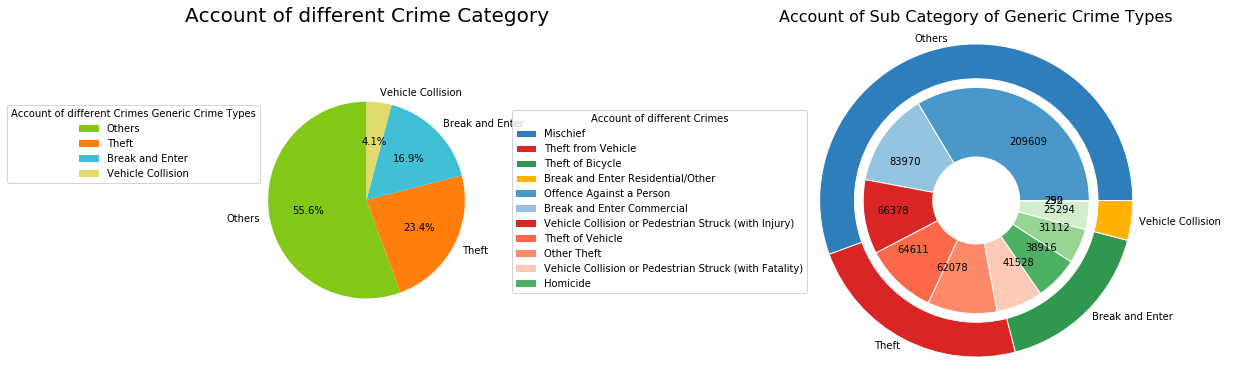

In [18]:
fig = plt.figure(figsize=(20,4))
#Visualization - Account of different Crimes Generic Crime Types
ax1 = fig.add_subplot(1,2,1)
crime_categorycount = data['CATEGORY'].value_counts().tolist()
crime_category = data['CATEGORY'].unique().tolist()
colors = ["#83c817", "#ff7f0e", "#41bfd5", "#e0db6a"]
ax1.pie(crime_categorycount, colors=colors,labels=crime_category, startangle=90, autopct='%.1f%%')
ax1.axis('equal')
ax1.legend(crime_category ,title="Account of different Crimes Generic Crime Types", bbox_to_anchor=(.23,0.7),loc='right', bbox_transform=plt.gcf().transFigure)
ax1.set_title('Account of different Crime Category', pad=70,fontsize=20)

#Visualization - Account of Sub Category of Generic Crime Types
ax2 = fig.add_subplot(1,2,2)
group_names = data['CATEGORY'].unique().tolist()
group_size=data['CATEGORY'].value_counts().tolist()
subgroup=data['TYPE'].unique().tolist()
subgroup_names=data['TYPE'].value_counts().tolist()
subgroup_size=data['TYPE'].value_counts().tolist()
# Create colors
a, b, c , d=[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens, plt.cm.autumn]
# First Ring (outside)
ax2.axis('equal')
mypie, _ = ax2.pie(group_size, radius=1.8, labels=group_names,labeldistance=1.05, colors=[a(0.7), b(0.7), c(0.7), d(0.7)] )
plt.setp( mypie, width=0.4, edgecolor='white')
# Second Ring (Inside)
mypie2, _ = ax2.pie(subgroup_size, radius=1.3, labels=subgroup_names, labeldistance=.6, colors=[a(0.6), a(0.4), b(0.7),b(0.5),b(0.4),b(0.2), c(0.6), c(0.4),c(0.2),d(0.6),d(0.4)])
ax2.legend(subgroup ,title="Account of different Crimes", bbox_to_anchor=(.61,0.5),loc='right', bbox_transform=plt.gcf().transFigure)
ax2.set_title('Account of Sub Category of Generic Crime Types', pad=70,fontsize=16)
plt.setp( mypie2, width=0.8, edgecolor='white')
plt.margins(0,0)
plt.show()

**Insight:**

Break and Enter (Break and Enter Residential/Other, Break and Enter Commercial) is the most popular Crime followed by Theft (Theft of Vehicle,Theft of bicycle and Theft from vehicle ).

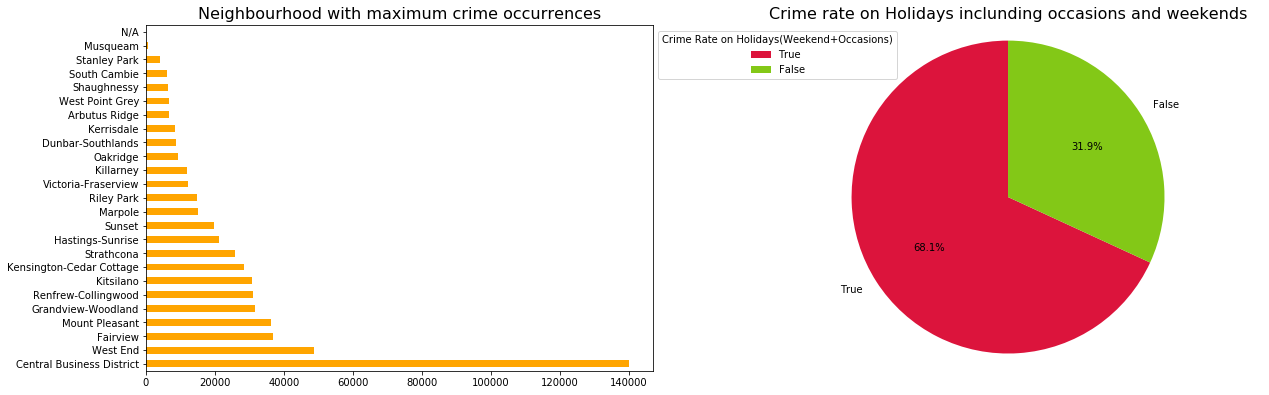

In [19]:
plt.figure(figsize=(20,14))
#Plot 1
plt.subplot(2,2,1)
data = data[data['HUNDRED_BLOCK'] != 'OFFSET TO PROTECT PRIVACY']
data['NEIGHBOURHOOD'].value_counts().plot.barh(color="orange")
plt.title("Neighbourhood with maximum crime occurrences",fontsize=16)
#Plot 2
ax1 = plt.subplot(2,2,2)
Holidaycount = data['ISOFFDAY'].value_counts().tolist()
HolidayTorF = data['ISOFFDAY'].unique().tolist()
colors = ["crimson", "#83c817"]
ax1.pie(Holidaycount, colors=colors,labels=HolidayTorF, startangle=90, autopct='%.1f%%')
ax1.axis('equal')
ax1.legend(HolidayTorF ,title="Crime Rate on Holidays(Weekend+Occasions)", bbox_to_anchor=(.65,0.85),loc='right', bbox_transform=plt.gcf().transFigure)
plt.title("Crime rate on Holidays inclunding occasions and weekends",fontsize=16)
plt.show()

**Insight:**

Central Business District is the most crime affected area in Vancuover. Also we can see that nearly 32% of crimes are taking place on holidays.

### Temporal Visualization

Text(0.5, 1.0, 'Changes in different Crime types count over the year')

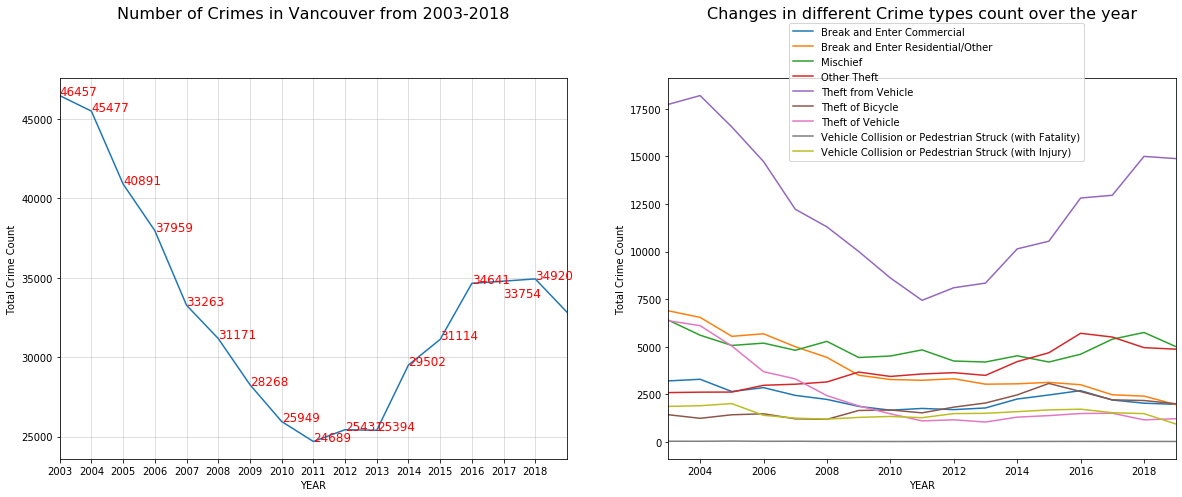

In [20]:
fig = plt.figure(figsize=(20,7))
#Visualization - Number of Crimes in Vancouver from 2003-2018
ax1 = fig.add_subplot(1,2,1)
ax = pd.value_counts(data[data.YEAR != 2017]['YEAR']).sort_index().plot(ax=ax1)
ax.set_title('Number of Crimes in Vancouver from 2003-2018', pad=60,fontsize=16)
ticks=data[data.YEAR != 2019]['YEAR'].unique()
ax.set_xticks(ticks)
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
ax.set_ylabel('Total Crime Count')
ax.set_xlabel('YEAR')
for i,j in pd.value_counts(data[data.YEAR != 2019]['YEAR']).sort_index().items():
    ax.annotate(str(j), xy=(i, j),color="red",fontsize=12)
#Visualization - Changes in different crime types count over the year
ax2 = fig.add_subplot(1,2,2)
data.groupby(['YEAR','TYPE']).count()['DATETIME'].unstack().plot(ax=ax2)
ax2.legend(bbox_to_anchor=(.84,1),loc='upper right', bbox_transform=plt.gcf().transFigure,prop={'size':10})
ax2.set_ylabel('Total Crime Count')
ax2.set_title('Changes in different Crime types count over the year', pad=60,fontsize=16)

**Insight:**

We can derive that crime in vancouver has overall decreased over the year from 2003 to 2011, and have slightly increased afterwards. 

Also, theft from vehicle remain the most popular crime over the years.

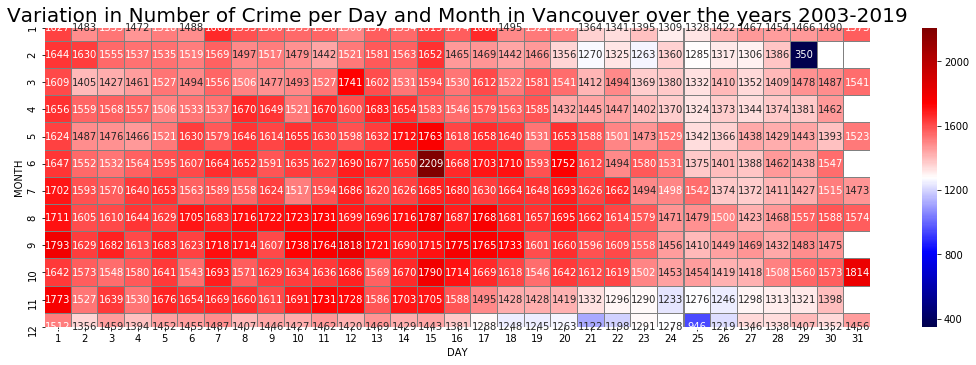

In [21]:
#Visualization - Average Number of Crime per DAY and Month
plt.figure(figsize=(18.5,5.5))
chron=pd.DataFrame(data.groupby(['DAY','MONTH']).count()).reset_index().rename(columns={'TYPE':'Total Crime'})[['MONTH','DAY','Total Crime']]
chron=chron.pivot('MONTH','DAY','Total Crime')
plt.title('Variation in Number of Crime per Day and Month in Vancouver over the years 2003-2019', fontsize=20)
sns.heatmap(chron,annot=True,fmt='g', cmap='seismic',linecolor='grey',linewidths=0.06)

**Insight:**

We notice that June 15 is having the maximum occurrences of crime, so we research about events that happend that day in Vancouver and found out about the Vancouver Stanley Cup riot in 2011.

Also, we notice that 1st day of every month is having more crimes. Considering the occasions, Christmas is comparatively calm but new year have more crime occurences.

Text(0.5, 1.0, 'Variation of Crime over different week days')

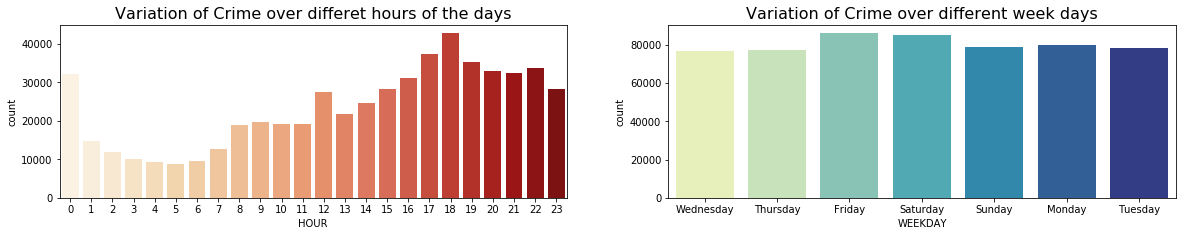

In [22]:
plt.figure(figsize=(20,7))
#Plot 1
plt.subplot(2,2,1)
sns.countplot(x='HOUR', data=data,palette='OrRd')
plt.title("Variation of Crime over differet hours of the days",fontsize=16)
#Plot 2
plt.subplot(2,2,2)
sns.countplot(x='WEEKDAY', data=data,palette='YlGnBu')
plt.title("Variation of Crime over different week days",fontsize=16)

**Insight:**

The most crime occured at 6 P.M most affected weekdays are Friday and Saturday. 

### Geo Visualization

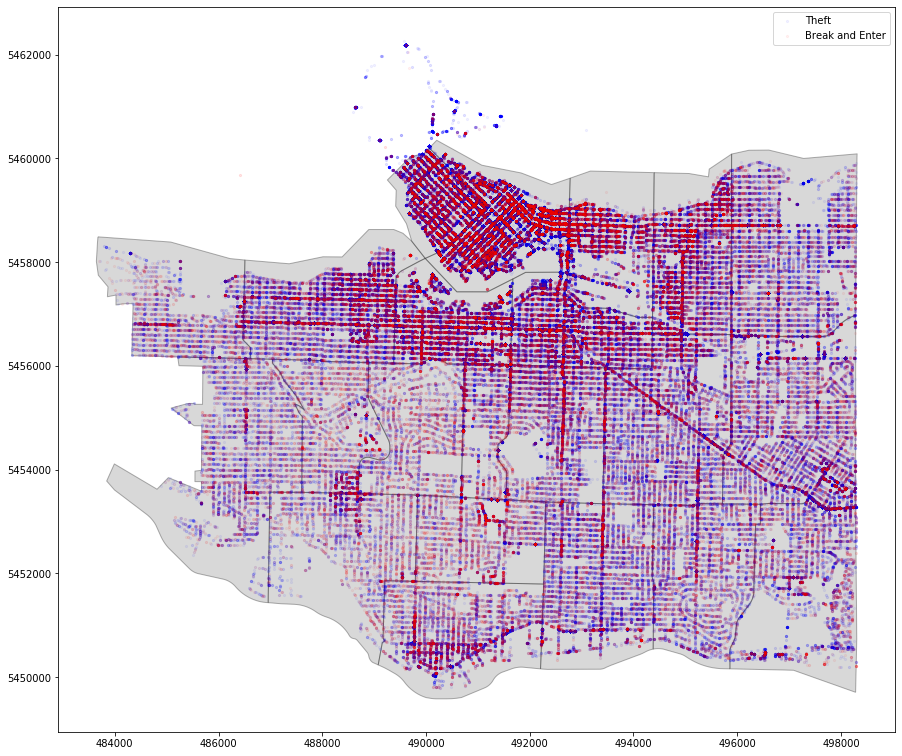

In [23]:
#Load shape file of Vancouver
vanc_map = gpd.read_file("local_area_boundary.shp")

crs = {'int':'epsg:4326'} #Coordinate reference system
geometry = [Point(xy) for xy in zip(data["X"], data["Y"])]

#Create a Geo Dataframe
geo_df = gpd.GeoDataFrame(data, crs = crs, geometry = geometry)

fig,ax = plt.subplots(figsize = (15,15))

#Plot the map
vanc_map.plot(ax = ax, alpha = 0.3, color ="grey", edgecolor='black')

#Plot theft and break and enter points
geo_df.loc[geo_df['CATEGORY']=='Theft'].plot(ax = ax, markersize = 5, color = "blue",alpha = 0.05, marker = "o", label = "Theft")
geo_df.loc[geo_df['CATEGORY']=='Break and Enter'].plot(ax = ax, markersize = 5, color = "red", alpha = 0.05, marker = "o", label = "Break and Enter")

plt.legend(prop = {'size': 10})

**Insight:**

From this we can see the most affected areas in Vancouver when it comes to categories **Theft** and **Break and Enter** which is Downtown.

# Experiment/Analysis

Before we start the experiment/analysis section, let's load the dataset we have so far using pickle.

In [24]:
p = open('data', 'rb')
data = pickle.load(p)
p.close()

**The methods and the algorithms**

For our analysis, we will be testing out two classifiers, decision tree and Gaussian naive Bayes, to use our dataset on.

Scikit's implementation will be used directly.

**The process**

After we tried filling in all the missing values in the column "NEIGHBOURHOOD", we should get rid of the entries that are not filled by our process above and are still missing the "NEIGHBOURHOOD" value.

In [25]:
data = data.query('NEIGHBOURHOOD != "N/A"')

First, we need to select features we will be using during the analysis.

After several tries, we found out that by using columns "Month", "DAY", "HOUR", "NEIGHBOURHOOD" and "ISOFFDAY", we can get the best results.

However, you are welcomed to play around with the "feature_cols" variable.

In [26]:
feature_cols = ['MONTH', 'DAY', 'HOUR', 'NEIGHBOURHOOD', 'ISOFFDAY']

data_X = data[feature_cols]
data_Y = data['TYPE']

Next, we will need to encode our features.

Since columns "TYPE", "NEIGHBOURHOOD" and "ISOFFDAY" are non-numerical values, we need to convert them into numbers before we can use the two columns for the analysis.

The encoder for the column "TYPE" has been printed out as an example.  From the output, we can see that "Break and Enter Commercial" will be encoded into 0, "Break and Enter Residential/Other" will be encoded into 1 and so on. 

In [27]:
le_neighbourhood = preprocessing.LabelEncoder()
le_neighbourhood.fit(data_X['NEIGHBOURHOOD'])

data_X['NEIGHBOURHOOD'] = le_neighbourhood.transform(data_X['NEIGHBOURHOOD'])

le_isoffday = preprocessing.LabelEncoder()
le_isoffday.fit(data_X['ISOFFDAY'])

data_X['ISOFFDAY'] = le_isoffday.transform(data_X['ISOFFDAY'])

le_type = preprocessing.LabelEncoder()
le_type.fit(data_Y)

data_Y = le_type.transform(data_Y)

list(le_type.classes_)

['Break and Enter Commercial',
 'Break and Enter Residential/Other',
 'Mischief',
 'No Crime',
 'Other Theft',
 'Theft from Vehicle',
 'Theft of Bicycle',
 'Theft of Vehicle',
 'Vehicle Collision or Pedestrian Struck (with Fatality)',
 'Vehicle Collision or Pedestrian Struck (with Injury)']

Next, we split our dataset into a training set and a testing set.  We will be using cross_val_score from sklearn, which will eliminate the need of splitting a validation set.  This will help maintain the size of our dataset.

In [28]:
train_X, test_X, train_Y, test_Y = train_test_split(data_X, data_Y, test_size = 0.25, random_state = 0)

Finally, we apply the classifiers.

Let's start with the decision tree classifier using default parameters first.

In [29]:
model_decisiontree = DecisionTreeClassifier(criterion="entropy")
model_decisiontree = model_decisiontree.fit(train_X, train_Y)

pred_Y = model_decisiontree.predict(test_X)

print("Accuracy:", metrics.accuracy_score(test_Y, pred_Y))

Accuracy: 0.8382875944196926


Next, let's try out the Gaussian naive Bayes classifier using default parameters as well.

In [30]:
model_gaussiannb = GaussianNB()
model_gaussiannb = model_gaussiannb.fit(train_X, train_Y)

pred_Y = model_gaussiannb.predict(test_X)

print("Accuracy:", metrics.accuracy_score(test_Y, pred_Y))

Accuracy: 0.8472419195070757


**Optimization**

After testing out the classifiers, it's time to do some optimization AKA hyperparameters tuning.

For the decision tree classifier, we can tune the hyperparameter "max_depth".  This controls the maximum depth of the tree.

For the Gaussian naive Bayes classifier, we can tune the hyperparameter "priors".  This controls the prior probabilities of the classes.  However, since we do not have those, we will skip optimization for the Gaussian naive Bayes classifier.

In order to decide which value the "max_depth" parameter the decision tree classifier should use, we will run a while loop trying out each depth value starting from 1.

The while loop will stop when the program determines it has already stored the best accuracy.  This is done using a threshold.

You are welcomed to play around with the "threshold" variable.

In addition, cross validation will be used here to ensure the program gets the correct "max_depth" value.

We will implement cross validation using cross_val_score from sklearn.  The validation will be completed on using 5-folds.

You are welcomed to play around with the "kfold" variable.

In [31]:
acc_decisiontree = []
scores_decisiontree = []

threshold = 0.005
kfold = 5
depth = 1

while(1):
    model = DecisionTreeClassifier(criterion="entropy", max_depth = depth)
    scores = cross_val_score(model, train_X, train_Y, cv = kfold)
    acc = scores.mean()
    
    acc_decisiontree.append(acc)
    scores_decisiontree.append(scores)
    
    if (max(acc_decisiontree) - threshold) >= acc:
        break
    else:
        depth += 1

After the best "max_depth" value is calculated, let's see how the "max_depth" value affected the accuracy of the decision tree classifier.

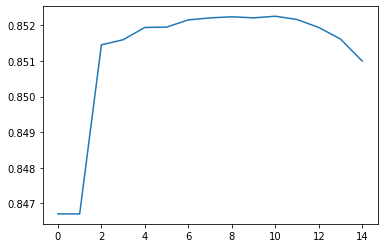

In [32]:
plt.plot(acc_decisiontree)

pos = acc_decisiontree.index(max(acc_decisiontree))

acc = acc_decisiontree[pos]
scores = scores_decisiontree[pos]

Let's try training the decision tree classifier again using the "max_depth" value we calculated.

In [33]:
model_decisiontree = DecisionTreeClassifier(criterion="entropy", max_depth = pos + 1)
model_decisiontree = model_decisiontree.fit(train_X, train_Y)

pred_Y = model_decisiontree.predict(test_X)

print("Accuracy:", metrics.accuracy_score(test_Y, pred_Y))

Accuracy: 0.8526812792641046


**Results and discussion**

As you can see, we can achieve around 84% accuracy with both the decision tree classifier and the Gaussian naive Bayes classifier.

Let's check out if we will encounter crime if we head to West End on September 1st at 1 P.M.  Let's suppose it is a work day.

In [34]:
my_day = pd.DataFrame()
my_day["MONTH"] = [9]
my_day["DAY"] = [1]
my_day["HOUR"] = [13]
my_day["NEIGHBOURHOOD"] = [ "West End" ]
my_day["ISOFFDAY"] = [ False ]

my_day['NEIGHBOURHOOD'] = le_neighbourhood.transform(my_day['NEIGHBOURHOOD'])
my_day['ISOFFDAY'] = le_isoffday.transform(my_day['ISOFFDAY'])

pred_my_day = model_decisiontree.predict(my_day)

if pred_my_day == 3:
    print("It seems like your day will be safe!")
else:
    print("Don't go!")

It seems like your day will be safe!


# Conclusion

**Summary**

In conclusion, Vancouver is a very safe city.  For some classifiers such as the logistic regression classifier (we ran some tests on the logistic regression classifier but decided against placing it on the report), the model predicts every test entry to be "No Crime".  This is because Vancouver's crime rate is so low, the probability you actually encounter one is almost impossible.

Let's take a look at our claims again.

1. Crime rate will spike in the afternoon, when people are getting out of work and school

This is correct.  We can see crime counts reaches its peak at around 18:00.  This is about the time people get out of work and school.

2. Crime rate will spike on off-days, which includes weekends and holidays.

This is also partially correct.  We thought crime rates should be highest on off-days.  Instead, we can see that crime counts on Friday and Saturday are higher than the rest of the week.  This is logical because most people are getting ready to enjoy their weekends on Friday after they get out of work (keep in mind crime count is highest after people start getting out of work and school) and getting ready to go back to work on Sunday, which might keep them from heading out.

It is interesting to note that while Friday and Saturday have the two highest crime counts of the week, Sunday is not far behind, being 3rd on the chart.  This also proves our claims.

In addition, with simple mathematics and a little knowledge of proportion, we can see that off-days (weekends and holidays) do have higher crime rates, although only by about 10% compared to other days.

3. There will be neighbourhoods with high specific crime rates, such as Downtown Eastside and property crimes, as mentioned above.

This is not properly analyzed, but with a quick inspection of the dataset, this is correct as well.

Apart from neighbourhoods with high specific crime rates, there are also days with high specific crime rates as well.  Whether it is a recurring day or non-recurring day.  For example, there seems to be a high rate of assault on New Years day.

**Future Works**

Apart from the decision tree classifier and the Gaussian naive Bayes classifier, we also tried using the multinomial naive Bayes classifier, perceptrons and logistic regression.  However, we were unable to optimize these three classifiers due to time constraints.

It would be interesting, however, to see the difference in prediction with these five classifiers given a dataset this large.

For improvement, we can start by implementing GridSearchCV as our cross validation method.  This would help in the optimization process in terms of both speed and accuracy.